# Binary 「 Movie Recommender System 」 for "a part of dataset ( u1 ) "

In [23]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
from torch.autograd import Variable

# Import datasets

In [24]:
movie = pd.read_csv("movies.dat",sep="::",header=None,engine="python",encoding = 'latin-1')

In [25]:
users=pd.read_csv("users.dat",sep="::",header=None,engine="python",encoding="latin-1")

In [26]:
ratings = pd.read_csv("ratings.dat",sep="::",header=None,engine="python",encoding="latin-1")

In [27]:
movie.head()

,0,1,2
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [28]:
# 3 : means user job's code
users.head()

,0,1,2,3,4
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


In [29]:
# 0 means user_id, 1 means movie_id, 2 means ratings, 3 timestamps
ratings.head()

,0,1,2,3
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


# Preparing training ant testing sets

In [30]:
# schema like the ratings_set 
training_set=pd.read_csv('u1.base',sep="\t",header=None)

In [31]:
training_set.head()

,0,1,2,3
0,1,1,5,874965758
1,1,2,3,876893171
2,1,3,4,878542960
3,1,4,3,876893119
4,1,5,3,889751712


In [32]:
# convert datatype to numpy arrays
training_set=np.array(training_set,dtype="int")

In [33]:
testing_set=pd.read_csv("u1.test",sep="\t",header=None)
testing_set=np.array(testing_set,dtype="int")

getting number of users and movies
- build matrix composed of users(rows),movies(columns),values(ratings)

In [34]:
nb_users=int(max(max(training_set[:,0]),max(testing_set[:,0])))
nb_movies=int(max(max(training_set[:,1]),max(testing_set[:,1])))

### convert the data to desired data structures

In [35]:
def convert(data):
    matrix=np.zeros([nb_users,nb_movies],dtype="int")
    for row in data:
        matrix[row[0]-1,row[1]-1]=row[2]

In [36]:
training_matrix=convert(training_set)
testing_matrix=convert(testing_set)

In [37]:
training_df=pd.DataFrame(training_matrix,index=range(1,nb_users+1),columns=range(1,nb_movies+1))
testing_df=pd.DataFrame(testing_matrix,index=range(1,nb_users+1),columns=range(1,nb_movies+1))

In [38]:
k=[1,2,3,4,5]
v=np.zeros(5)
d=dict(zip(k,v))
for i in training_matrix[0]:
    if i==0:
        pass
    else:
        d[i]+=1

## Convert the data into Torch Tensor

In [39]:
training_set=torch.FloatTensor(training_matrix)
testing_set=torch.FloatTensor(testing_matrix)

## Convert ratings to binary format 1( like ) or 0( not like )

In [1]:
def convertBinayRatings(data):
    # 兩種方式去換值
    data=np.where(data==0,-1,data)
    data[data==1]=0
    data[data==2]=0 # the selected items will show in 1d format
    data[data>=3]=1
    return torch.FloatTensor(data)

In [41]:
training_set=convertBinayRatings(training_set)
testing_set=convertBinayRatings(testing_set)

## Build RBM neural netowrk model by using pytorch
- implementation algorithm
    - Update weights
    - input and output vector can keep individual dimension
    - replace log-likelihood with "Contrastive Divergency by Geoffrey Hinton"

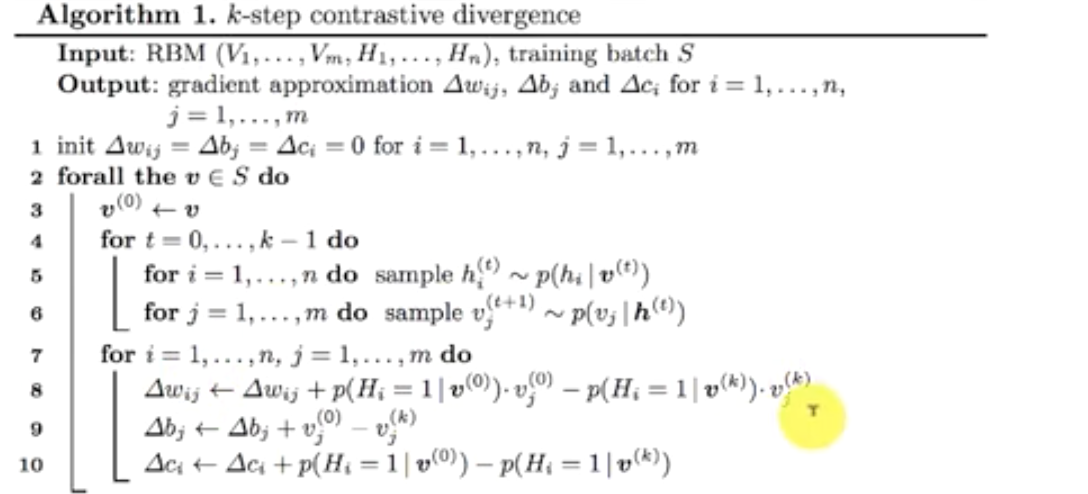

In [42]:
class RBM():
    def __init__(self,nv,nh): # number of visible nodes , # number of hidden nodes
        self.W = torch.randn(nh,nv) 
        self.a = torch.randn(1,nh) 
        self.b = torch.randn(1,nv) # 1 means batch
    def sample_h(self,x):
        wx=torch.mm(x,self.W.t()) # matrix multiplication 
        p_h_given_v = torch.sigmoid(wx+self.a.expand_as(wx))
        return p_h_given_v,torch.bernoulli(p_h_given_v)  # use bernouli distribution
    def sample_v(self,y):
        wy=torch.mm(y,self.W) 
        activation=wy+self.b.expand_as(wy) # each line mini batch
        p_v_given_h = torch.sigmoid(activation) 
        return p_v_given_h,torch.bernoulli(p_v_given_h)
    
    # declare training method (including the contrastive divergence), 
    # vk is visible nodes's content after k iterations,
    # ph0 is the first_iteration probability of hidden node
    # phk is the probability of hidden node after k iterations
    def train(self, v0, vk, ph0, phk): 
        self.W += torch.mm(ph0.t(),v0) - torch.mm(phk.t(),vk)
        self.b += torch.sum((v0-vk),0) # keep 2 dimension 
        self.a += torch.sum((ph0-phk),0) # keep 2 dimension

### Build RBM object

In [43]:
nv=len(training_set[0])
nh=100 # any number we choose
batch_size=100 # also tunable

# Training RBM models
- keep original data to verify training loss
- compute ph0
- contrastive divergence k
    - compute bernopuli(the vh,and vk), and use these value to interaction
    - and each th
- compute phk after contrastive divergence k
    - learining : update weights
    - before learning let unrated keep unrated for compute training loss
- compute training loss
    - RMSE or MAE

In [44]:
rbm=RBM(nv,nh)
nb_eopchs = 10
result=[]
for epoch in range(1,nb_eopchs+1):
    train_loss = 0
    s=0
    for id_user in range(0,nb_users-batch_size,batch_size): # batch-gradient methods
        vk = training_set[id_user:id_user+batch_size] # 0-99 100-199
        v0 = training_set[id_user:id_user+batch_size] # verify training loss's original data
        ph0,_=rbm.sample_h(v0) # to only get the first result, not use variable to accept second result
        for k in range(10): # contrastive divergence
            _,hk = rbm.sample_h(vk) # v0 is the target / (keep original data to compute error difference)
            _,vk = rbm.sample_v(hk)
            # training is on not in the rating, Let equals -1 
            vk[v0<0] = v0[v0<0] 
        phk,_=rbm.sample_h(vk)
        rbm.train(v0,vk,ph0,phk)
        #train_loss += torch.mean(torch.abs(v0[v0>=0] - vk[v0>=0]))
        result.append((v0[v0>=0]-vk[v0>=0])**2)
        train_loss += np.sqrt(torch.mean((v0[v0>=0]-vk[v0>=0])**2))
        #print(id_user)
        s+=1
    
    print(train_loss)
    print('epoch ' + str(epoch) + ', loss: '+str( train_loss/s)) # show the average loss of each batch in every epoch

5.247475177355654
epoch 1, loss: 0.5830527974839615
4.305920865353679
epoch 2, loss: 0.4784356517059643
4.499462740166873
epoch 3, loss: 0.4999403044629859
4.469657114172604
epoch 4, loss: 0.4966285682414004
4.482459609538055
epoch 5, loss: 0.4980510677264506
4.5478228205876325
epoch 6, loss: 0.5053136467319592
4.472030165325791
epoch 7, loss: 0.4968922405917545
4.487614934677868
epoch 8, loss: 0.49862388163087423
4.472057783715587
epoch 9, loss: 0.49689530930173187
4.463445466065032
epoch 10, loss: 0.4959383851183369


### Testing RBM
- MCMC is not the random walk, it is blind walk, ex:it has to more steps to find the straight line
    - it's probability is not the same

In [45]:
test_loss = 0
s=0.0
result=[]
for id_user in range(0,nb_users):

    v = training_set[id_user:id_user+1] #  use training_set predict unrated in movies(actual data is in test_data, 
    vt = testing_set[id_user:id_user+1] #  use testing_set help us to evaluate the predictions)
    # testing contrastive divergency : do one gibbs sampling when do testing 
    
    if len(vt[vt>=0])>0:# we can make the prediction in this condition # make sure the user exist
        _,h = rbm.sample_h(v) 
        _,v = rbm.sample_v(h)   # simultaneously to predict ratings for the movies that use in the dataset has never seen
        v[vt<0]=vt[vt<0]
        result.append(v)
        #test_loss += torch.mean(torch.abs(vt[vt>=0] - v[vt>=0]))
        test_loss += np.sqrt(torch.mean((vt[vt>=0]-v[vt>=0])**2)) #
        s+=1

print(test_loss)
print("test loss:",test_loss/s)

210.77922241334127
test loss: 0.4592139921859287
